## Exploratoy Data Analysis

NOTE: Before concating the dataframes, it is necessary to add a timeleft category to completed sales.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import re
%matplotlib inline

In [100]:
active_sales = pd.read_csv('./cleaned_csv_3_1', index_col=0)
active_sales_2 = pd.read_csv('./cleaned_csv_3_8', index_col=0)
completed_sales = pd.read_csv('./cleaned_completed_3_4', index_col=0)

In [101]:
print('Total market cost on March 1st: ',active_sales['current_price'].sum())
print('Total market cost on March 8th: ',active_sales_2['current_price'].sum())
print('Money  committed in auction on 3/1: ', 
      active_sales[active_sales['bidCount'] >= 1]['current_price'].sum())
print('Money  committed in auction on 3/8: ', 
      active_sales_2[active_sales_2['bidCount'] >= 1]['current_price'].sum())


Total market cost on March 1st:  2457117.77
Total market cost on March 8th:  2170470.89
Money  committed in auction on 3/1:  6174.7300000000005
Money  committed in auction on 3/8:  5679.950000000001


In [102]:
print('Percentage of completed sales that are auctions', 
      completed_sales[completed_sales['listingType'] == 'Auction'].shape[0] / completed_sales.shape[0])

print('Time span for completed sales', '\n', completed_sales['endTime'].min(), '\n',
      completed_sales['endTime'].max())

print('Total sales during 8+ days, ', completed_sales['current_price'].sum())

Percentage of completed sales that are auctions 0.5032
Time span for completed sales 
 2018-02-24 02:41:34 
 2018-03-04 16:31:26
Total sales during 8+ days,  312567.91000000003


In [103]:
active_sales = pd.concat([active_sales, active_sales_2], axis=0).reset_index(drop=True)

In [104]:
#8851 duplicates dropped

active_sales = active_sales.drop(list(active_sales[active_sales.duplicated(
    subset='itemId', keep='last')].index), axis=0)

In [105]:
#adding timeLeft column to completed sales, with 0 value
completed_sales['timeLeft'] = pd.Timedelta(0)

In [106]:
#fixing time deltas
deltas = []
for val in active_sales['timeLeft']:
    time = val[:-10]
    deltas.append(pd.Timedelta(time))

active_sales['timeLeft'] = deltas

In [107]:
#merged dataframe
df = pd.concat([active_sales, completed_sales], axis=0).reset_index(drop=True)

In [108]:
#dropping additional duplicates after merge (first run found 300)
df = df.drop(list(df[df.duplicated(
    subset='itemId', keep='first')].index), axis = 0)

In [109]:
#dropping roman coin jewelry categories

df = df.drop(list(df.loc[df['categoryId'] == 137843].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 164343].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 548].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 164341].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 45157].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 29223].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 13993].index), axis=0)

#dropping additional categories likely not to be individual coins
drop_cols = df['categoryId'].value_counts().reset_index()
val_to_drop = list(drop_cols.loc[drop_cols['categoryId'] < 12]['index'])
df = df.drop(df[df['categoryId'].isin(val_to_drop)].index, axis=0)

In [110]:
#dropping sales not in USD
df = df.drop(list(df[df['current_currency'] != 'USD'].index), axis=0)

#all USD, dropping
df = df.drop('currencyid_conv', axis=1)

In [111]:
#Creating dummy for if the sale is in the USA
df['seller_in_us'] = df['country'].apply(lambda x: 1 if x == 'US' else 0)
df = df.drop('country', axis=1)

In [112]:
#Converting to datetime 
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

In [113]:
#Should be zero now
print(df.loc[df.duplicated()].shape)
df = df.drop_duplicates()

(0, 28)


In [114]:
#3036 of the 14856 sales are auctions 
df.loc[df['listingType'] =='Auction'].shape

(2973, 28)

Text(0.5,0,'Number of Bids in Auctions')

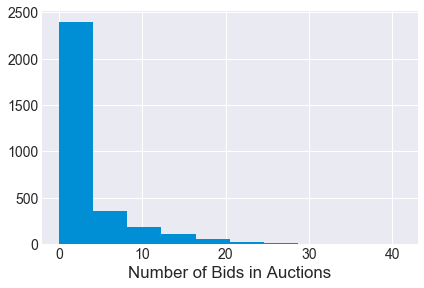

In [34]:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
df.loc[df['listingType'] =='Auction']['bidCount'].hist()
plt.xlabel('Number of Bids in Auctions')

Number of Auctions by Listing Type 
 StoreInventory    10108
Auction            3151
FixedPrice         1409
AuctionWithBIN      188
Name: listingType, dtype: int64


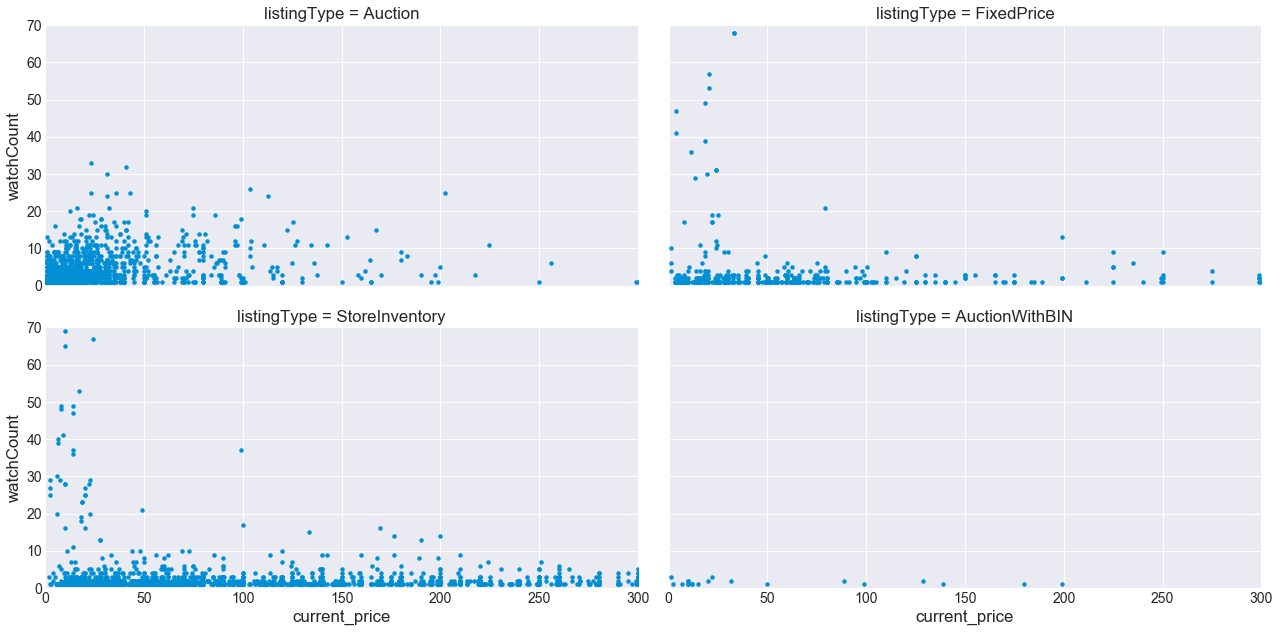

In [35]:
#what is the relationship between watchcount and current price? 
print('Number of Auctions by Listing Type', '\n', df['listingType'].value_counts())
df.pipe(sns.FacetGrid, col='listingType', col_wrap=2,
       aspect=2, size=4.5).map(plt.scatter, 'current_price',
                             'watchCount', s=15)
plt.ylim(0, 70)
plt.xlim(0, 300)
plt.tight_layout()

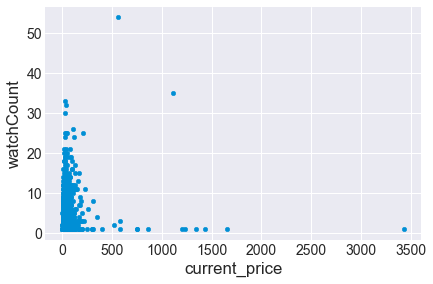

In [36]:
df.loc[df['listingType'] == 'Auction'].plot('current_price', 'watchCount', kind='scatter')

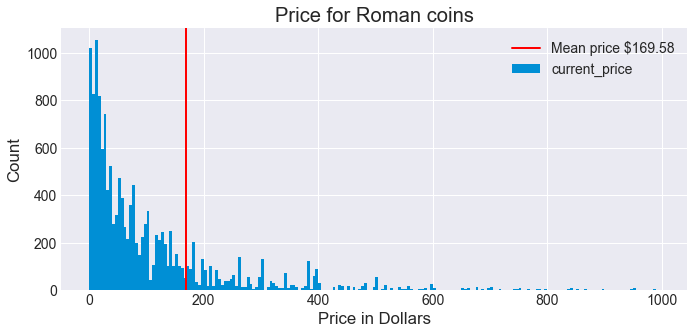

In [40]:
fig, ax = plt.subplots(figsize=(10, 4.5))
bins = np.arange(0, 1000, 5)
ax = ax.hist(df['current_price'], bins=bins)
plt.xlabel('Price in Dollars')
plt.ylabel('Count')
plt.title('Price for Roman coins')
plt.axvline(df['current_price'].mean(), lw=2, c='red', label = 'Mean price ${0:.2f}'.format(
                                                            df['current_price'].mean()))
plt.legend()

In [47]:
#A massive outlier, representing a rare coin of Emperor Caligula's sisters, with whom he was reported to have had an affair. 
df['current_price'].describe(percentiles =[0.25, 0.50, 0.75, 0.90, 0.95])

count    14856.000000
mean       169.580479
std        929.021034
min          0.010000
25%         19.990000
50%         59.735000
75%        140.000000
90%        300.000000
95%        440.000000
max      37500.000000
Name: current_price, dtype: float64

In [348]:
#277 coins have current_prices greater than 1000 dollars
len(list(df.loc[df['current_price'] > 1000].index))

277

In [327]:
df['shippingType'] = df['shippingType'].apply(lambda x: 'International' if x in ['CalculatedDomesticFlatInternational',
                                                                                'FlatDomesticCalculatedInternational'] else x)

Text(0.5,1,'Coin price by shipping type (Avg. shipping cost above)')

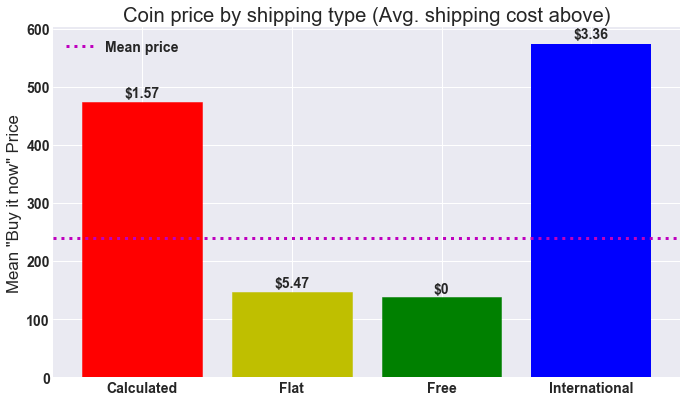

In [328]:
from matplotlib import rc

rc('font', weight='bold')
shipping_graph = df.groupby('shippingType', as_index=False)['buyItNowPrice'].mean()
shipping_graph = shipping_graph.loc[shipping_graph['shippingType'].isin(['Calculated', 'Flat', 'Free', 'International'])]

avg_cost = ['$1.57', '$5.47', '$0', '$3.36']
fig, ax = plt.subplots(figsize=(10, 6))
barlist = plt.bar(shipping_graph['shippingType'], shipping_graph['buyItNowPrice'], 
                  color='blue', )

barlist[0].set_color('r')
barlist[1].set_color('y')
barlist[2].set_color('g')
plt.axhline(df['buyItNowPrice'].mean(), lw=3, c='m', ls='dotted', label='Mean price')
plt.ylabel('Mean "Buy it now" Price')
for num,rect in enumerate(barlist):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                avg_cost[num],
                ha='center', va='bottom',)


plt.legend()
plt.title('Coin price by shipping type (Avg. shipping cost above)')

(0, 500)

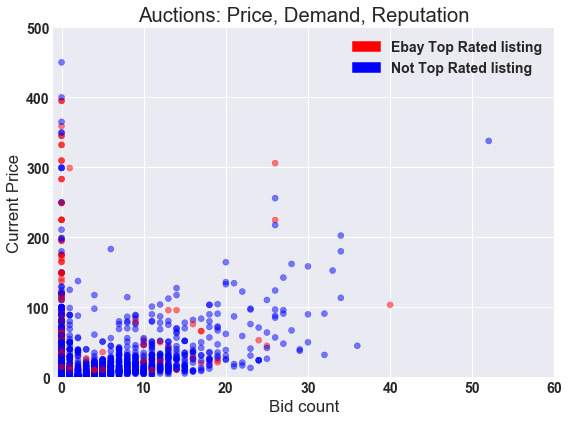

In [329]:
import matplotlib.patches as mpatches
auction_interest = df.loc[df['listingType'] == 'Auction']
rc('font', weight='bold')
plt.subplots(figsize=(8, 6))
plt.scatter(auction_interest['bidCount'], 
            auction_interest['current_price'], c=auction_interest['topRatedListing'].apply(
            lambda x: 'r' if x == 1 else 'b'), alpha=0.5)


legend_patch = mpatches.Patch(color='red', label='Ebay Top Rated listing')
legend_patch2 = mpatches.Patch(color='blue', label='Not Top Rated listing')                            
plt.legend(handles=[legend_patch, legend_patch2])

plt.title('Auctions: Price, Demand, Reputation')
plt.xlabel('Bid count')
plt.ylabel('Current Price')
plt.xlim(-1, 60)
plt.ylim(0, 500)

In [330]:
#pulling individual emperors from titles

#splitting and rejoining URLtitles
df['URLTitle'] = df['URLTitle'].str.split('-').apply(lambda x: " ".join(x))
df['URLTitle'] = df['URLTitle'].str.lower()

roman_emperors = ['Augustus', 'Tiberius', 'Caligula', 'Claudius', 'Nero', 'Galba', 'Otho', 'Aulus Vitellius', 'Vespasian', 'Titus', 
                  'Domitian', 'Nerva', 'Trajan', 'Hadrian', 'Antoninus Pius', 'Marcus Aurelius', 'Lucius Verus', 'Commodus', 'Publius Helvius Pertinax', 
                  'Marcus Didius Severus Julianus', 'Septimius Severus', 'Caracalla', 'Publius Septimius Geta', 'Macrinus', 'Elagabalus', 'Severus Alexander', 
                  'Maximinus', 'Gordian I', 'Gordian II', 'Pupienus Maximus', 'Balbinus', 'Gordian III', 'Philip', 'Decius', 'Hostilian', 'Gallus', 'Aemilian', 'Valerian', 'Gallienus', 
                  'Claudius II Gothicus', 'Quintillus', 'Aurelian', 'Tacitus', 'Florian', 'Probus', 'Carus', 'Numerian', 'Carinus', 'Diocletian', 'Maximian', 'Constantius I',
                  'Galerius',  'Constantine I ', 'Galerius Valerius Maximinus', 'Licinius', 'Constantine II ', 'Constantius II', 'Constans I', 'Gallus Caesar', 'Julian', 'Jovian', 
                  'Valentinian I', 'Valens', 'Gratian', 'Valentinian II', 'Theodosius I', 'Arcadius', 'Magnus Maximus', 'Honorius', 'Theodosius II', 'Constantius III', 'Valentinian III',
                  'Marcian', 'Petronius Maximus', 'Avitus', 'Majorian', 'Anthemius', 'Olybrius', 'Glycerius', 'Julius Nepos', 'Romulus Augustulus', 'Leo I', 'Leo II', 'Zeno']

roman_emperors = [x.lower() for x in roman_emperors]

emperors = []

for title in df['URLTitle']:
    if 'lot' in title: 
        emperors.append('LOT')
    else:
        emps = re.findall(r"(?=("+'|'.join(roman_emperors)+r"))",title)
        if emps:
            emperors.append(emps)
        else: 
            emperors.append('unknown')

df['emperor_in_title'] = emperors

In [331]:
#There are 891 lots (buzz word for multiple coins)
print('Number of lots: ', np.sum(df['emperor_in_title'] == 'LOT'))
print('Neither a lot nor an emperor: ', np.sum(df['emperor_in_title'] == 'unknown'))

Number of lots:  873
Neither a lot nor an emperor:  5433


In [332]:
#Eliminating non-coin sales
posters = []

for num, val in enumerate(df['URLTitle']):
    if 'poster' in val:
        posters.append(num)

df = df.drop(posters, axis=0).reset_index(drop=True)


In [333]:
#Identifying whether there are one or more emperors in the title (i.e. is it one coin or more)
singles = []
multiples = []
for num, val in enumerate(df['emperor_in_title']):
    if type(val) != float:
        if len(val) > 1:
            multiples.append(num)
        elif len(val) == 1:
            singles.append(num)

In [334]:
#Extracting coin material from titles 
metals = ['gold', 'silver', 'bronze', 'orichalcum', 'copper']

metal = []
for title in df['URLTitle']:
    coin = re.findall(r"(?=("+'|'.join(metals)+r"))",title)
    if coin:
        metal.append(coin)
    else: 
        metal.append(['unknown'])
        
df['coin_metal'] = metal

In [335]:
def metal_cleaner(col):
    """Removes metal values from lists"""
    try:
        multi = ' '.join(col)
        return multi
    except:
        single = col[0]
        return single

df['coin_metal'] = df['coin_metal'].apply(metal_cleaner)

In [336]:
#365 observations include a jewelery keyword, dropping
jewelery = []

for num, val in enumerate(df['URLTitle']):
    if 'earring' in val:
        jewelery.append(num)
    elif 'pendant' in val:
        jewelery.append(num)
    elif 'bracelet'in val:
        jewelery.append(num)
    elif 'necklace' in val:
        jewelery.append(num)

df = df.drop(jewelery, axis=0).reset_index(drop=True)

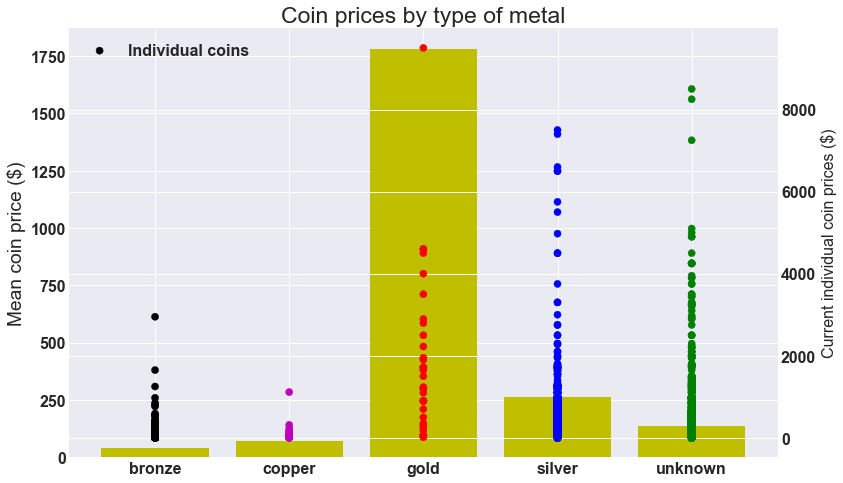

In [338]:
metal_graph = df[df['coin_metal'].isin(['gold', 'silver', 'bronze', 'copper', 'unknown'])].loc[df['current_price'] < 10000]
metal_graph2 = metal_graph.groupby('coin_metal', as_index=False)['current_price'].mean().sort_values(by=['current_price'])

rc('font', weight='bold', size=16)
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(metal_graph2['coin_metal'], metal_graph2['current_price'], color='y')
plt.ylabel('Mean coin price ($)')
ax2 = ax.twinx()
colors = {'gold':'r', 'silver':'b', 'bronze': 'k', 'copper': 'm', 'unknown': 'g'}
ax2.scatter(metal_graph['coin_metal'], metal_graph['current_price'], label='Individual coins',s=50, c=metal_graph['coin_metal'].map(colors))
plt.ylabel('Current individual coin prices ($)', size=16)
plt.title('Coin prices by type of metal')
plt.legend(loc=2)
fig.tight_layout()

In [339]:
def emperor_cleaner(col):
    """eliminating duplicate emperor names within same listing, making them strings"""   
    if col == 'unknown' or col == 'LOT':
        return col
    else:
        if len(col) > 1:
            emp = list(set(col))
            clean = ' '.join(emp)
            return clean
        elif len(col) == 1:
            emp = col[0]
            return emp

df['emperor_in_title'] = df['emperor_in_title'].apply(emperor_cleaner)

In [343]:
#Preparing data to examine price/availability by emperor/reign/time period

emperor_graph = df.groupby('emperor_in_title', as_index=False).agg({
    'current_price':['median','max','min'], 
    'autoPay': 'count'}).sort_values([('autoPay', 'count')]).reset_index(drop=True)

emperor_graph.columns = emperor_graph.columns.droplevel()
emperor_graph.columns = ['Emperor', 'Median price', 'Max price', 'Min price', 'Unique sales']


emperor_graph.loc[emperor_graph['Median price'] > 2000]

In [354]:
#dropping Nero Galba (1 sale, $22,500), carus marcus aurelius (1 sale, $4000)
#dropping lots and unknown values
emperor_graph = emperor_graph.drop(list(emperor_graph[emperor_graph['Emperor'].isin([
    'LOT','unknown', 'nero galba', 'carus marcus aurelius'])].index), axis=0)

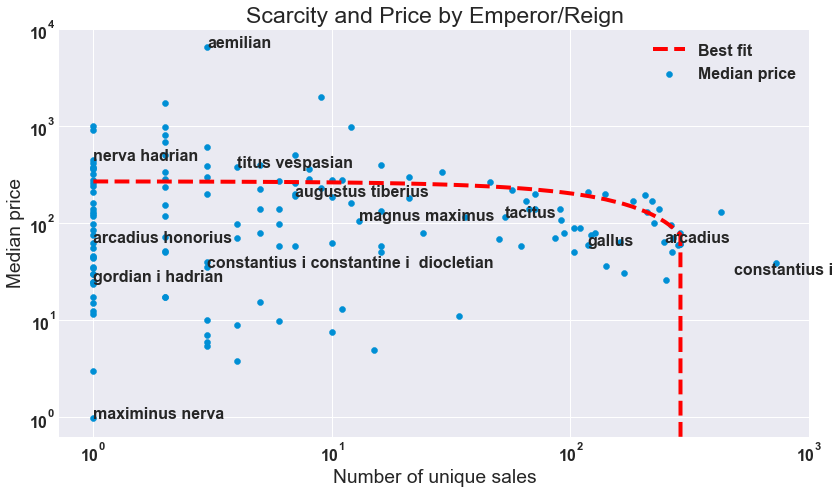

In [381]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(emperor_graph['Unique sales'], emperor_graph['Median price'])
plt.semilogy()
plt.semilogx()

for index, row in emperor_graph.iterrows():
    prices = []
    if index % 14 == 0:
        if row['Emperor'] != 'marcus aurelius hadrian':
            ax.annotate(row['Emperor'], (row['Unique sales'], row['Median price']))

#manually entered, reconfigure to make robust for new data
ax.annotate('maximinus nerva', (1, 0.99))
ax.annotate('aemilian', (3, 6500))
ax.annotate('constantius i', (485, 30.11))

ax.plot(np.unique(emperor_graph['Unique sales']), 
         np.poly1d(np.polyfit(emperor_graph['Unique sales'], 
                              emperor_graph['Median price'], 1))
                 (np.unique(emperor_graph['Unique sales'])), c='r', linestyle='dashed', label='Best fit')
plt.ylabel('Median price')
plt.xlabel('Number of unique sales')
plt.title('Scarcity and Price by Emperor/Reign')
plt.legend()
plt.show()

In [401]:
df.head()

,URLTitle,autoPay,bestOfferEnabled,bidCount,buyItNowAvailable,buyItNowPrice,categoryId,current_currency,current_price,endTime,...,shipping_cost,startTime,timeLeft,title,topRatedListing,value_conv,watchCount,emperor_in_title,coin_metal,seller_in_us
0,slabbed roman imperial constantine great era a...,1,0,NaN,0,NaN,4734,USD,5.99,2018-03-24 04:00:20,...,3.95,2016-08-31 04:00:20,22 days 02:25:28,Slabbed Roman Imperial Constantine The Great E...,1,5.99,1050.0,unknown,bronze,1
1,lot 5 ancient roman widows mite sized bronze c...,1,0,NaN,0,NaN,4734,USD,18.50,2018-03-16 22:43:13,...,0.00,2017-12-16 22:43:13,14 days 21:08:21,Lot of 5 Ancient Roman Widows Mite Sized Bronz...,1,18.50,35.0,LOT,bronze,1
2,lot 50 ancient roman coins medium low quality,0,0,13.0,0,NaN,4734,USD,12.50,2018-03-02 03:22:05,...,3.50,2018-02-23 03:22:05,0 days 01:47:13,Lot of 50 Ancient Roman Coins Medium-Low Quality,1,12.50,4.0,LOT,unknown,1
3,higher quality ancient roman coin nero altar 4...,0,0,7.0,0,NaN,4734,USD,13.50,2018-03-05 01:34:06,...,NaN,2018-02-26 01:34:06,2 days 23:59:14,"Higher Quality Ancient Roman Coin; Nero, Altar...",0,13.50,13.0,nero,unknown,1
4,one authentic ancient roman empire bronze coin...,0,0,NaN,0,NaN,4734,USD,9.99,2018-03-26 16:50:25,...,3.99,2014-08-14 16:50:25,24 days 15:15:33,ONE Authentic Ancient ROMAN EMPIRE BRONZE COIN...,0,9.99,409.0,unknown,bronze,1


In [394]:
df['value_conv']

0          5.99
1         18.50
2         12.50
3         13.50
4          9.99
5         10.00
6         31.00
7          1.25
8         15.50
9         30.00
10        34.50
11        12.50
12        19.00
13        30.00
14        15.50
15         3.95
16        26.00
17        17.95
18        23.50
19        45.00
20         2.25
21         8.72
22        27.00
23        23.50
24        40.00
25         5.50
26        20.62
27        18.00
28         6.50
29        27.00
          ...  
13864     29.19
13865    129.99
13866     20.01
13867      8.50
13868     13.45
13869      7.39
13870      4.80
13871     14.88
13872     11.00
13873     14.50
13874      5.05
13875     49.99
13876     59.99
13877     49.99
13878     20.01
13879     72.00
13880     59.95
13881     20.01
13882     72.00
13883     10.50
13884     20.01
13885     20.01
13886     69.00
13887     20.01
13888    865.00
13889     72.68
13890      2.24
13891    249.00
13892     49.95
13893      7.99
Name: value_conv, Length

In [393]:
df.columns

Index(['URLTitle', 'autoPay', 'bestOfferEnabled', 'bidCount',
       'buyItNowAvailable', 'buyItNowPrice', 'categoryId', 'country',
       'current_currency', 'current_price', 'endTime', 'expeditedShipping',
       'handlingTime', 'itemId', 'listingType', 'location', 'paymentMethod',
       'postalCode', 'productId', 'returnsNotAccepted', 'shippingType',
       'shipping_cost', 'startTime', 'timeLeft', 'title', 'topRatedListing',
       'value_conv', 'watchCount', 'emperor_in_title', 'coin_metal'],
      dtype='object')